# Tutorial: Permittivities based on Perturbation Theory

This demo file shows how to use the model published in [Neumaier et al. (2022)](https://doi.org/10.1016/j.fluid.2021.113346) and [Rueben et al. (2023)](https://doi.org/10.1021/acs.jced.3c00323) to compute relative static permittivities.
This notebook is a bit lengthy because it shows all the different ways to create permittivity parameters and densities. However, once you've chosen a method, permittivities can be computed within a few lines of code.

First, we need to import the model and other important packages:

In [1]:
# Permittivity, density, and plots
from Thermo import DensityCalculator    
from Permittivity import PermittivityModel, PermittivityParameters, PermittivityError
from Molecule.Fragmentation import Fragmentation

# Common Python packages
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In our database, substances are uniquely identified by their `substance_id` as the number the substance has in the joint database of the Dortmund Data Bank and the ThermoML database. Multiple other identifiers such as `iupac_name`, `cas` number, `canonical_smiles` are available. The database can also be indexed by these. Here, we use the `substance_id`:

In [2]:
parameter_database = pd.read_csv("Parameters/PermittivityParameterDatabase.csv", index_col="substance_id")

## 1. Creating `PermittivityParameters`

We now choose a substance, for example, 1-propanol with the `substance_id` = 139. Let's look at the parameter database for this substance. Apart from the parameters, the database also contains information on the deviations of the original fit and some more info on the substance:

In [3]:
substance = 139

param_db = parameter_database.loc[[substance]]

param_db

iupac_name smiles      cas  \
substance_id                                
139           propan-1-ol   CCCO  71-23-8   

                                              inchi      family Scheme  \
substance_id                                                             
139           InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3  n-alcohols      P   

              a11_mu2      a2  a12_alpha  n_points   MAD  MARD/percent  \
substance_id                                                             
139              8.27  0.1467        0.0        89  0.56          3.78   

              T_crit/K  T_min/K  
substance_id                     
139              536.9   147.05

To use the model, we need a set of `PermittivityParameters` first. Currently, there are three ways to create these:
- From the parameters directly: provide `a11_mu2`, `a12_alpha`, and `a2`. If not all three parameters are provided, we set the parameters that are not provided to 0.
- From the database: provide `query`, and optionally `query_option` and `filename_database` if you do not use the file in `Parameters/`.
- From the group contribution method: provide `molecule` which is a dictionary with the number of respective groups in that molecule, and optionally `filename_gc_database` if you do not use the file in `Parameters/`.

In all three cases, we can provide lists to create mixture parameters. For the mixtures, PC-SAFT and the homosegmented GC method for PC-SAFT are available to compute densities.

We shortly demonstrate all three approaches. For this purpose, we first extract the parameters from the parameter database (we could also provide our own parameters) and then create the `PermittivityParameters` object:

In [4]:
# Extract parameters from DataFrame:
a11_mu2 = parameter_database.loc[(substance, "a11_mu2")]
a12_alpha = parameter_database.loc[(substance, "a12_alpha")]
a2 = parameter_database.loc[(substance, "a2")]

# Create `PermittivityParameters`:
permittivity_param_from_values = PermittivityParameters(a11_mu2=a11_mu2, a12_alpha=a12_alpha, a2=a2)

# Let's look at them:
print(permittivity_param_from_values)

a11_mu2: 8.27, a12_alpha: 0.0, a2: 0.1467


Alternatively, we can use the second method providing the `substance_id` as a query to the database:

In [5]:
# Create `PermittivityParameters`:
permittivity_param_from_database = PermittivityParameters(query=139)

# Let's look at them:
print(permittivity_param_from_database)

a11_mu2: 8.27, a12_alpha: 0.0, a2: 0.1467


Or for a mixture:

In [6]:
permittivity_param_mix = PermittivityParameters(query=[139,150])

print(permittivity_param_mix)

a11_mu2: [8.27, 8.913], a12_alpha: [0.0, 51.538], a2: [0.1467, 0.1541]


If we want to use the group contribution method, we need to provide a fragmentation. For this purpose, we can load the existing fragmentation or create a new one from SMILES code(s):

In [7]:
# Loads existing fragmentation
fragmentation = Fragmentation()

# Get fragmentation for specific substance, also returns success (boolean) and number of functional groups
molecule, success, n_functional_groups = fragmentation.get_fragmentation(139)

print(molecule)

{'CH3': 1.0, 'CH2': 2.0, 'OH_1': 1.0}


In [8]:
# Or create new fragmenation
df_frag = fragmentation.new_fragmentation(smiles=["CCO"])

# Get fragmentation for specific substance, also returns success (boolean) and number of functional groups
molecule, success, n_functional_groups = fragmentation.get_fragmentation("CCO")

print(molecule)

{'CH3': 1.0, 'CH2': 1.0, 'OH_1': 1.0}


Now we use this fragmentation to create `PermittivityParameters`:

In [9]:
permittivity_param_from_gc = PermittivityParameters(molecule=molecule)

print(permittivity_param_from_gc)

a11_mu2: 7.5678156626635475, a12_alpha: 3.295776182448406, a2: 0.155012327080736


## 2. Computing densities

Our model evaluates permittivities for a given `temperature` and `density`. However, most of the time, we will not have the density in advance. 

Currently, we have three methods to get to the density:
- From density correlation (`DensityCorrelation`) for liquid density, where the density is only a function of the temperature (`density_option = "correlation"`).
- From the PC-SAFT Equation of State (`EoS`) using pure component PC-SAFT parameters, where the density is both a function of temperature and pressure (`density_option = "pc-saft"`).
- From the PC-SAFT Equation of State (`EoS`) using the [homosegmented group contribution method](https://pubs.acs.org/doi/full/10.1021/ie502203w) to compute the pure component PC-SAFT parameters (`density_option = "gc-pc-saft"`).

In general, we use the `DensityCalculator` object. Here, we can set up the density in all three ways.

### I. Calculate density with density correlation


For the density correlation, we need the `density_data` DataFrame providing us with the coefficients of the density correlation:

In [10]:
density_data = pd.read_csv("Parameters/ParametersDensityCorrelation.csv", index_col="substance_id")

density_data.loc[[substance]]

iupac_name smiles      cas  \
substance_id                                
139           propan-1-ol   CCCO  71-23-8   

                                              inchi      A       B  T_crit/K  \
substance_id                                                                   
139           InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3  0.277  0.2333     536.9   

              rho_crit/(mol/dm3)     T_max/K  n_points  MARD/percent  
substance_id                                                          
139                        4.601  536.899999      1841           0.1

First, we create the `DensityCalculator`. We do not need to provide `density_correlation` or `eos` yet. If we continue to `setup_density`, we can still provide all the info to set up one of these two (depending on the `density_option` we choose). Setting up the density with `density_calculator.setup_density()` gives us a `status`, potentially an `error_message`, and what we are actually looking for, the `density` object which contains either `density_correlation` or `eos`, depending on the `density_option` we choose.

In [11]:
density_calculator_correl = DensityCalculator()

# To set up density correlation, we just need the substance_id, the density_option, and the density_data. The remaining arguments are for the other two options.
status, error_message, density_correlation = density_calculator_correl.setup_density(substance_id=substance, density_option="correlation", density_data=density_data)

With this `density_calculator_correl`, we can now evaluate the density for a given temperature raster described by its minimum temperature `t_min`. Here, we take the minimum temperature from the ?`PermittivityParameterDatabase` above. Per default, the densities are calculated in the unit particles per cubic Angström (#/A3), because that's what our model takes, but you can also specify `unit = "mol/dm3"` if you wish otherwise.

In [12]:
# we take the minimum temperature from the PermittivityParameterDatabase above
t_min = parameter_database.loc[(substance, "T_min/K")]

temperatures, densities = density_calculator_correl.calculate_density_raster(t_min=t_min)

plt.xlabel("Temperature in K")
plt.ylabel("Density in #/A3")
plt.plot(temperatures, densities)

plt.show()

Alternatively, you can calculate densities at specified temperatures with the `DensityCorrelation` object directly, for example at the temperatures where experimental data is provided:

In [13]:
# Exemplary temperatures
t_exp = np.array([150, 200, 350, 450])

density_exp = density_correlation.evaluate(t=t_exp, unit="#/A3")

plt.xlabel("Temperature in K")
plt.ylabel("Experimental data density in #/A3")
plt.plot(t_exp, density_exp, marker="x", linestyle="")

plt.show()

### II. Calculate densities with PC-SAFT

To calculate densities with PC-SAFT, we have to setup an `EoS` (Equation of State) object. We again set this object up with a `DensityCalculator`. We need to provide the CAS number because the CAS number is used as a search option for the PC-SAFT parameters.

In [14]:
density_calculator_pcsaft = DensityCalculator()

# To set up the equation of state, we need the substance_id, the density_option, the CAS number, and the information on the minimum temperature (melting points). The remaining arguments are for the other two options.
cas = parameter_database.loc[(substance, "cas")]
# we take the minimum temperature from the PermittivityParameterDatabase above
t_min = parameter_database.loc[(substance, "T_min/K")]

status, error_message, density_pcsaft = density_calculator_pcsaft.setup_density(substance_id=substance, density_option="pc-saft", cas=cas, fragmentation=fragmentation, t_min=t_min)

The object `density_pcsaft` now contains both the SAFT parameters `density_pcsaft.param` and the equation of state `density_pcsaft.eos`:

In [15]:
density_pcsaft.param

|component|molarweight|$m$|$\sigma$|$\varepsilon$|$\mu$|$Q$|$\kappa_{AB}$|$\varepsilon_{AB}$|$N_A$|$N_B$|
|-|-|-|-|-|-|-|-|-|-|-|
|propan-1-ol|60.058|3.64845|3.01344|213.87925|0|0|0.03851|1980.59746|1|1|

Similarly to the density correlation, we can use the `density_calculator_pcsaft` to give us a density raster and the `density_pcsaft` to calculate experimental densities for the same temperatures `t_exp` as above. The only difference is that we now need to provide the pressures also. We can also provide `nan` values for the pressure. Then, a default pressure of `max(1 bar, p_sat(T))` will be taken.

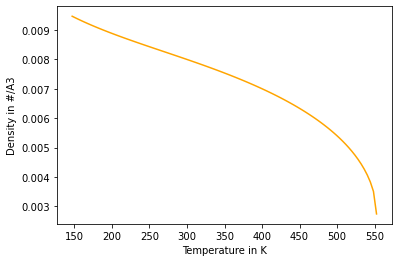

In [16]:
temperatures, densities = density_calculator_pcsaft.calculate_density_raster(t_min=t_min)

plt.xlabel("Temperature in K")
plt.ylabel("Density in #/A3")
plt.plot(temperatures, densities, label="PC-SAFT densities", color="orange")

plt.show()

### III. Calculate densities with Homosegmented GC method for PC-SAFT

We can also setup an `EoS` (Equation of State) object from the group contribution method by Sauer et al. (2017). We again set this object up with a `DensityCalculator`. Here, we need to provide our `molecule` from above, or alternatively, a `Fragmentation` object with our fragmenation info from above and the `substance_id` so that the molecule dictionary can be looked up:

In [17]:
density_calculator_gcpcsaft = DensityCalculator()

# we take the minimum temperature from the PermittivityParameterDatabase above
t_min = parameter_database.loc[(substance, "T_min/K")]

# We take the fragmentation we derived above `molecule`. Alternatively, we can also provide a `Fragmentation` object with the substance_id
status, error_message, density_gcpcsaft = density_calculator_gcpcsaft.setup_density(substance_id=substance, density_option="gc-pc-saft", molecule=molecule, t_min=t_min)

temperatures, densities = density_calculator_gcpcsaft.calculate_density_raster(t_min=t_min)

plt.xlabel("Temperature in K")
plt.ylabel("Density in #/A3")
plt.plot(temperatures, densities, label="Homo GC-PC-SAFT densities", color="orange")

plt.show()

## 2. Computing permittivities

Next, we can create the model (`PermittivityModel`) from the parameters. For simplicity, we take the parameters we've created first. For all pure substances, this works exactly the same when temperature and density are provided. For mixtures, the mixture compostion must be specified additionally.
With this object, we can evaluate permittivities.

In [18]:
permittivity_model = PermittivityModel(permittivity_parameters=permittivity_param_from_values)

Enough of the prematter! Now we want to use our `Permittivity` model called `permittivity_model` we created above to calculate actual permittivities. Once we have the densities, it's pretty easy. We just need to provide temperatures and densities. We will now evaluate the permittivities at the experimental temperatures `t_exp`. These we can compare with the experimental permittivities if available. Furthermore, we will evaluate the permittivities along the temperature raster `temperatures` to plot the permittivities over the temperature:

In [19]:
# Experimental temperatures:
# t_exp and density_exp from above derived using density correlation
epsilon_r_calc = permittivity_model.evaluate_permittivity(temperature=t_exp, density=density_exp)

# Raster temperatures
epsilon_r_raster = permittivity_model.evaluate_permittivity(temperature=temperatures, density=densities)

plt.xlabel("Temperature in K")
plt.ylabel("Permittivity")
plt.plot(temperatures, epsilon_r_raster, label="Model", color="orange")

plt.legend()

plt.show()